# Iris Dataset

The goal is the classify the various iris observations into their correct labels. I am trying to use this  Notebook as a way to learn, but also teach about classification, KNN and KFold cross validation.  

## Getting the Data

For our Iris dataset we are using the data provided by UCI Machine Learning Repository. In order to make the data usable we read it into a Pandas dataframe.  We then split our data into the dependent variable y (the type of iris) and the independent variables X (the measurements).  We are calling .values  in order to make X and y NumPy ndarrays instead of leaving them as a dataframe in the case of X, and a series in the case of y. Ndarrays are significantly faster to work with than both Pandas objects as both a series and a dataframe require more overhead for things such as data type checking.  Note that y would have been a series because it is a one-dimensional object whereas X would have been a dataframe because it is two-dimensional. 

In [0]:
import pandas as pd
import numpy as np

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(url, names = ['sepal_length','sepal_width','petal_length','petal_width','species'])

X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

## Splitting our Data

Next, we need to split our data into 4 sets. We need a set of independent variables (X_train) and a set of dependent variables (y_train) to train our model on. We also need data to test our model on to see how accurate it is. This comes in the way of X_test and y_test. As you can see this is done with the use of sklearn's train_test_split function. The test_size parameter is a value between 0 and 1 that represents how much of the data should be allocated to the testing variables. We use .2 as 20% test size is fairly standard. There are many additional parameters you can set, one of which is random_state which makes it so each time the code is run the split is done in the same way.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Making our Model

For our classification model we will be using the k-nearest neighbors model. If you look at the graph below you will see all our data points from our iris dataframe. Pick a random spot on the grid not already plotted, this will be your testing point.  If you have k = 1 in the k-nearest neighbors model, then the species of your testing point is just the species of the nearest plotted point. If you have k = 5 then the species of your point is whichever species is most occurring out of the 5 closest plotted points. This value k is called a hyperparameter and we need to find the right value for it as to not make our model overfit or underfit our dataset. To visualize this data, we are using seaborn and matplotlib, seaborn is built on matplotlib and adds some additional functionality.

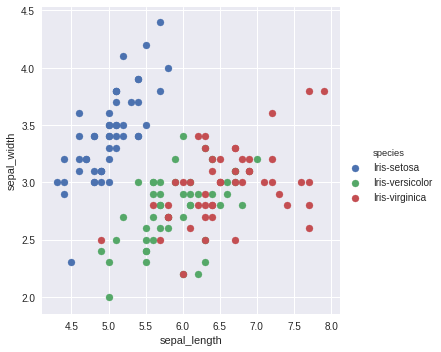

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

grid = sns.FacetGrid(df,hue='species',size = 5)
grid.map(plt.scatter,'sepal_length','sepal_width')
grid.add_legend()

# TODO:  accuracy_score and how it varies based on our split
  

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_range = list(range(1,26))
accuracy_scores = []

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(X_train,y_train)
  knn_pred = knn.predict(X_test)
  accuracy_scores.append(accuracy_score(y_test,knn_pred))

# TODO: explain graph generically (results won't be reproduced)

In [0]:

plt.plot(k_range,accuracy_scores)
plt.xlabel('Value of K')
plt.ylabel('Accuracy')
plt.title('Accuracy for each Value of K in KNN')

# TODO: talk about confusion matrix and metrics we can derive from them,

In [0]:
from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)
knn_cm = confusion_matrix(y_test,knn_pred)

# TODO: talking about benefits of Kfold cross validation as well as drawbacks, talk about hyperparamters

In [0]:
from sklearn.model_selection import cross_val_score
knn_cross = KNeighborsClassifier(n_neighbors = 5)
cross_val_scores = cross_val_score(knn_cross,X,y, cv = 10, scoring='accuracy')

# TODO: explain graph

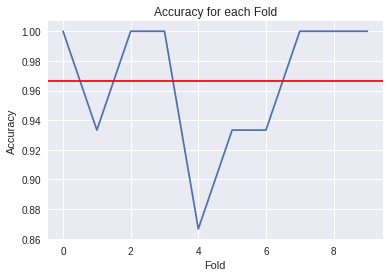

In [0]:
plt.plot(list(range(10)),cross_val_scores)
plt.axhline(y = cross_val_scores.mean(),color = 'red')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy for each Fold')
plt.show()

# TODO: explain using Kfold cross validation for tuning hyperparams

In [0]:
k_range = list(range(1,31))
k_scores = []
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(X_train,y_train)
  cross_val_scores = cross_val_score(knn,X,y, cv = 10, scoring='accuracy')
  k_scores.append(cross_val_scores.mean())

# TODO: Explain graph

In [0]:
plt.plot(k_range,k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross Validated Accuracy')
plt.title('Cross Validated Accuracy for each Value of K')

# TODO: explain why we picked 20 for KNN and explain our expected accuracy

In [0]:
knn = KNeighborsClassifier(n_neighbors=20)
best_knn_score = cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean()

### Acknowledgements

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.